<h1 align="center">
    <font size="24">
        <u>TIME SERIES ANALYSIS WITH XGBOOST AND LSTM</u>
    </font>
</h1>



## Abstract

The focus of this work was to estimate the future price of the Apple depending on a time window that the user is free to establish.
The methodology followed went from the data extraction, where yahoo finance library helped to get the daily data from the stock. After gathering and cleaning the data, the observations where clustered into windowed arrays that were used as inputs in order to train an XGBoost algorithm.
The expected output was the time frame indicated by the user of this code.


In [1]:
import pandas as pd
from scipy import stats 
from datetime import timedelta
from sklearn.metrics import mean_absolute_error
import xgboost as xgb
from xgboost import plot_importance, plot_tree
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
import numpy as np
import os
import tensorflow as tf
import warnings
import matplotlib
warnings.filterwarnings("ignore")

In [2]:
PERCENTAGE = .995

WINDOW = 2
PREDICTION_SCOPE = 0

## UDFs

In [17]:
def plotting(y_val, y_test, pred_test, mae, WINDOW, PREDICTION_SCOPE):
    
    """This function returns a graph where:
        - Validation Set
        - Test Set
        - Future Prediction
        - Upper Bound
        - Lower Bound
    """
    
    ploting_pred = [y_test[-1], pred_test]
    ploting_test = [y_val[-1]]+list(y_test)

    time = (len(y_val)-1)+(len(ploting_test)-1)+(len(ploting_pred)-1)

    test_time_init = time-(len(ploting_test)-1)-(len(ploting_pred)-1)
    test_time_end = time-(len(ploting_pred)-1)+1

    pred_time_init = time-(len(ploting_pred)-1)
    pred_time_end = time+1

    x_ticks = list(stock_prices.index[-time:])+[stock_prices.index[-1]+timedelta(PREDICTION_SCOPE+1)]

    values_for_bounds = list(y_val)+list(y_test)+list(pred_test)
    upper_band = values_for_bounds+mae
    lower_band = values_for_bounds-mae
    
    print(f"For used windowed data: {WINDOW}")
    print(f"Prediction scope for date {x_ticks[-1]} / {PREDICTION_SCOPE+1} days")
    print(f"The predicted price is {str(round(ploting_pred[-1][0],2))}$")
    print(f"With a spread of MAE is {round(mae,2)}")
    print()
    
    plt.figure(figsize=(16, 8))

    plt.plot(list(range(test_time_init, test_time_end)),ploting_test, marker="$m$", color="orange")
    plt.plot(list(range(pred_time_init, pred_time_end)),ploting_pred,marker="$m$", color="red")
    plt.plot(y_val, marker="$m$")

    plt.plot(upper_band, color="grey", alpha=.3)
    plt.plot(lower_band, color="grey", alpha=.3)

    plt.fill_between(list(range(0, time+1)),upper_band, lower_band, color="grey", alpha=.1)

    plt.xticks(list(range(0-1, time)), x_ticks, rotation=45)
    plt.text(time-0.5, ploting_pred[-1]+2, str(round(ploting_pred[-1][0],2))+"$", size=11, color='red')
    plt.title(f"Target price for date {x_ticks[-1]} / {PREDICTION_SCOPE+1} days, with used past data of {WINDOW} days and a MAE of {round(mae,2)}", size=15)
    plt.legend(["Testing Set (input for Prediction)", "Prediction", "Validation"])
    plt.show()
    
    print()
    print("-----------------------------------------------------------------------------")
    print()

In [18]:
def sp500_log_rets(tickers):
    
    """Returns the logarithmic returns from the SP500"""
    
    stock_prices = yf.download(tickers, start="2015-11-30", end="2021-11-30")["Close"]
    log_rets = {}
    for index, ticker in enumerate(tickers):
        log_rets[ticker] = np.log(stock_prices[ticker]/stock_prices[ticker].shift(1))
    return log_rets

In [7]:
def windowing(train, val, WINDOW, PREDICTION_SCOPE):
    
    """Divides the inserted data into a list of lists. Where the shape of the data becomes and additional axe, which is time
    Input:
        - Train Set
        - Validation Set
        - WINDOW: the desired window
        - PREDICTION_SCOPE: The period in the future you want to analyze
    """
    
    X_train = []
    y_train = []
    X_test = []
    y_test = []

    for i in range(len(train)-(WINDOW+PREDICTION_SCOPE)):
        X, y = np.array(train.iloc[i:i+WINDOW, :-1]), np.array(train.iloc[i+WINDOW+PREDICTION_SCOPE, -1])
        X_train.append(X)
        y_train.append(y)

    for i in range(len(val)-(window+PREDICTION_SCOPE)):
        X, y = np.array(val.iloc[i:i+WINDOW, :-1]), np.array(val.iloc[i+WINDOW+PREDICTION_SCOPE, -1])
        X_test.append(X)
        y_test.append(y)
        
    
    return X_train, y_train, X_test, y_test

In [8]:
def feature_engineering(data):
    
    """
    The function applies future engineering to the data in order to get more information out of the inserted data.
    """
    
    #FEATURE ENGINEERING
    data["Day"] = data.index.day
    data["Month"] = data.index.day
    data["Year"] = data.index.day
    data["Weekday"] = data.index.weekday
    data["Upper_Shape"] = data["High"]-np.maximum(data["Open"], data["Close"])
    data["Lower_Shape"] = np.minimum(data["Open"], data["Close"])-data["Low"]
    data["Close_y"] = data["Close"]
    data.drop("Close",1,  inplace=True)
    return data

In [9]:
def train_validation_split(train, percentage):
    """
    Divides the training set into train and validation set depending on the percentage indicated
    """
    train_set = train.iloc[:int(len(train)*percentage)]
    validation_set = train.iloc[int(len(train)*percentage):]
    return train_set, validation_set

In [10]:
def log_returns(train, percentage):
    """
    Returns log returns
    """
    
    train_logrets = np.log(train.iloc[:int(len(train)*percentage)]["Close_y"]/train.iloc[:int(len(train)*percentage)]["Close_y"].shift(1))
    val_logrets = np.log(train.iloc[int(len(train)*percentage):]["Close_y"]/train.iloc[int(len(train)*percentage):]["Close_y"].shift(1))
    return train_logrets, val_logrets

# XGBoost


XGBoost, is one of the most highly used supervised ML algorithms nowadays.

The algorithm uses a more optimized way to implement a tree based algorithm.

The methodology followed by this algorithm is the following. XGBoost uses a Greedy algorithm for the building of its tree, meaning it uses a simple intuitive way to optimze the algorithm. This is done by making a prediction (which acts as a threshols), before starting to evaluate the rest of the observations, which then turn into other thresholds, and so on.

This methods enables it to manage huge amount of data very quickly.

In the case of regression, it basically build up a Regression Tree through the residuals of each data point to the initial prediction. Then we split the data into portions and compare one to another and see which one is better at splitting the residuals into clusters of similar values.

For more insights into how this algorithm works, check out this video from [StatQuest](https://www.youtube.com/watch?v=OtD8wVaFm6E&t=649s)

In [11]:
stock_prices = yf.download("AAPL", start="2001-11-30")
SPY = yf.download("SPY", start="2001-11-30")["Close"]

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [23]:
rets = np.log(stock_prices["Close"]/stock_prices["Close"].shift(1))

In [32]:
stock_prices.tail()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2022-01-14,171.339996,173.779999,171.089996,173.070007,173.070007,80355000
2022-01-18,171.509995,172.539993,169.410004,169.800003,169.800003,90956700
2022-01-19,170.000000,171.080002,165.940002,166.229996,166.229996,94815000
2022-01-20,166.979996,169.679993,164.179993,164.509995,164.509995,91420500
2022-01-21,164.419998,166.330002,162.300003,162.410004,162.410004,122501300


In [33]:
stock_prices.describe()

,Open,High,Low,Close,Adj Close,Volume
count,5072.000000,5072.000000,5072.000000,5072.000000,5072.000000,5.072000e+03
mean,26.925009,27.210555,26.641129,26.935729,25.759891,4.273004e+08
std,36.198960,36.608116,35.805080,36.219130,36.191346,3.867942e+08
min,0.231964,0.235536,0.227143,0.234286,0.200869,3.934000e+07
25%,3.025803,3.068929,2.986697,3.026161,2.594525,1.463856e+08
50%,14.418036,14.586607,14.277322,14.454821,12.414800,3.029852e+08
75%,32.500000,32.689375,32.225624,32.496251,29.670328,5.837370e+08
max,182.630005,182.940002,179.119995,182.009995,182.009995,3.372970e+09


In [13]:
tickers = ["AAPL", "MSFT", "TSLA", "AMZN", "SPY"]

In [14]:
log_rets = sp500_log_rets(tickers)

[*********************100%***********************]  5 of 5 completed


In [15]:
#Annual rets for the selected tickers
ann_rets = {}
for ticker in log_rets.keys():
    ann_rets[ticker] = str(round(annualized_rets(log_rets[ticker])*100,2))+"%"
ann_rets

{'AAPL': '41.25%',
 'MSFT': '47.46%',
 'TSLA': '71.34%',
 'AMZN': '40.87%',
 'SPY': '18.42%'}

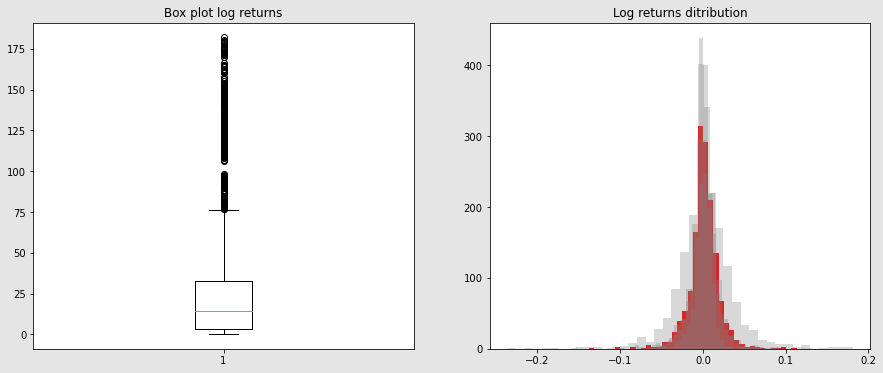

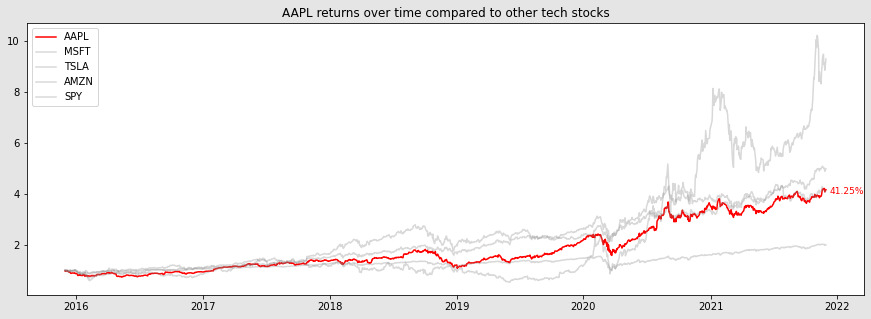

In [16]:
fig, ax = plt.subplots(1, 2, figsize=(15, 6))
fig.patch.set_facecolor('grey')
fig.patch.set_alpha(0.2)
for i in log_rets.keys():
    if i=="AAPL":
        ax[1].hist(log_rets[i], bins=40, color = "red")
        ax[0].boxplot(stock_prices["Close"])
        ax[0].set_title("Box plot log returns")
        ax[1].set_title("Log returns ditribution")
    else:
        ax[1].hist(log_rets[i], bins=40, color = "grey", alpha=.3)
        ax[0].set_title("Box plot log returns")
        ax[1].set_title("Log returns ditribution")


fig,ax = plt.subplots(figsize=(15,5))
fig.patch.set_facecolor('grey')
fig.patch.set_alpha(0.2)
for i in log_rets.keys():
    if i=="AAPL":
        ax.plot((1+log_rets[i]).cumprod(), color="red")

    else:
        ax.plot((1+log_rets[i]).cumprod(), color="grey", alpha=.3)

ax.legend(tickers)
ax.set_title("AAPL returns over time compared to other tech stocks")
ax.text(18970, 4, ann_rets["AAPL"], size=9, color='red')

plt.show()

## Feature Engineering

We will firt make the analysis forecasting 1 period ahead

In [15]:
stock_prices = feature_engineering(stock_prices)

In [18]:
stock_prices.tail()

,Open,High,Low,Adj Close,Volume,Day,Month,Year,Weekday,Upper_Shape,Lower_Shape,Close_y
Date,,,,,,,,,,,,
2022-01-14,171.339996,173.779999,171.089996,173.070007,80355000,14,14,14,4,0.709991,0.250000,173.070007
2022-01-18,171.509995,172.539993,169.410004,169.800003,90956700,18,18,18,1,1.029999,0.389999,169.800003
2022-01-19,170.000000,171.080002,165.940002,166.229996,94815000,19,19,19,2,1.080002,0.289993,166.229996
2022-01-20,166.979996,169.679993,164.179993,164.509995,91420500,20,20,20,3,2.699997,0.330002,164.509995
2022-01-21,164.419998,166.330002,162.300003,162.410004,122501300,21,21,21,4,1.910004,0.110001,162.410004


Split between train and test set

In [19]:
train = stock_prices.iloc[:int(len(stock_prices))-WINDOW]
test = stock_prices.iloc[-WINDOW:]

In [20]:
print(train.shape)
print(test.shape)

(5070, 12)
(2, 12)


Here are some functions that pretend to ease us the work while applying the same algorithm on different period forecasts

In [21]:
train_set, validation_set = train_validation_split(train, PERCENTAGE)

In [22]:
X_train, y_train, X_val, y_val = windowing(train_set, validation_set, WINDOW, PREDICTION_SCOPE)

Text(0.5, 1.0, 'Distribution of the Validation set')

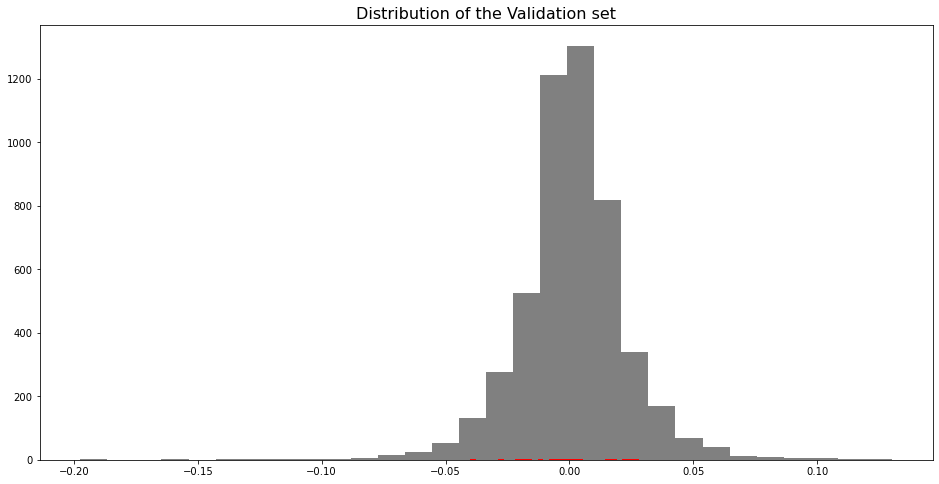

In [23]:
train_logrets , val_logrets = log_returns(train, PERCENTAGE) 

plt.figure(figsize=(16, 8))
plt.hist(train_logrets, bins=30, color = "grey")
plt.hist(val_logrets, bins=30, color = "red")
plt.title("Distribution of the Validation set", size=16)

In [24]:
#The shaded area is used if we wanted to validate the model. I am using the last data in order to make a prediction

X_train = np.array(X_train)
y_train = np.array(y_train)

X_val = np.array(X_val)
y_val = np.array(y_val)



X_train = X_train.reshape(X_train.shape[0], -1)
X_val = X_val.reshape(X_val.shape[0], -1)

In [25]:
print(X_train.shape)
print(X_val.shape)

print(y_train.shape)
print(y_val.shape)

(5042, 22)
(24, 22)
(5042,)
(24,)


In [26]:
xgb_model = xgb.XGBRegressor(gamma=.1, learning_rate=.2)
xgb_model.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             gamma=0.1, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.2, max_delta_step=0,
             max_depth=6, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=100, n_jobs=8,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)

In [27]:
pred_val = xgb_model.predict(X_val)

In [28]:
mae = mean_absolute_error(y_val, pred_val)
print(mae)

3.708533604939779


Text(0.5, 1.0, 'The MAE for this period is: 3.709')

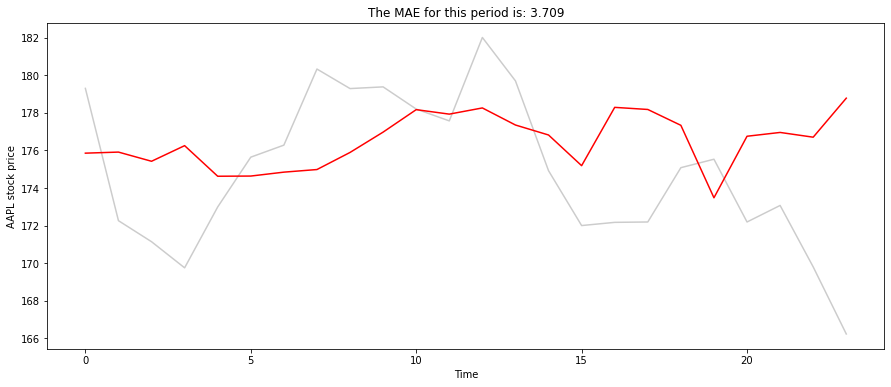

In [29]:
plt.figure(figsize=(15, 6))

plt.plot(y_val, color="grey", alpha=.4)
plt.plot(pred_val, color="red")

plt.xlabel("Time")
plt.ylabel("AAPL stock price")
plt.title(f"The MAE for this period is: {round(mae, 3)}")

### Evaluation on the Test Set

In [30]:
X_test = np.array(test.iloc[:, :-1])
y_test = np.array(test.iloc[:, -1])

X_test.shape

(2, 11)

In [31]:
X_test = X_test.reshape(1, -1)

X_test.shape

(1, 22)

In [32]:
pred_test = xgb_model.predict(X_test)

In [33]:
print(f"The prediction of the AAPL stock for Period {stock_prices.index[-1]+timedelta(PREDICTION_SCOPE+1)}, using data from the past {WINDOW} periods is: {pred_test[0]}, considering a spread of {round(mae, 2)}")

The prediction of the AAPL stock for Period 2022-01-22 00:00:00, using data from the past 2 periods is: 167.33567810058594, considering a spread of 3.71


For used windowed data: 2
Prediction scope for date 2022-01-22 00:00:00 / 1 days
The predicted price is 167.34$
With a spread of MAE is 3.71



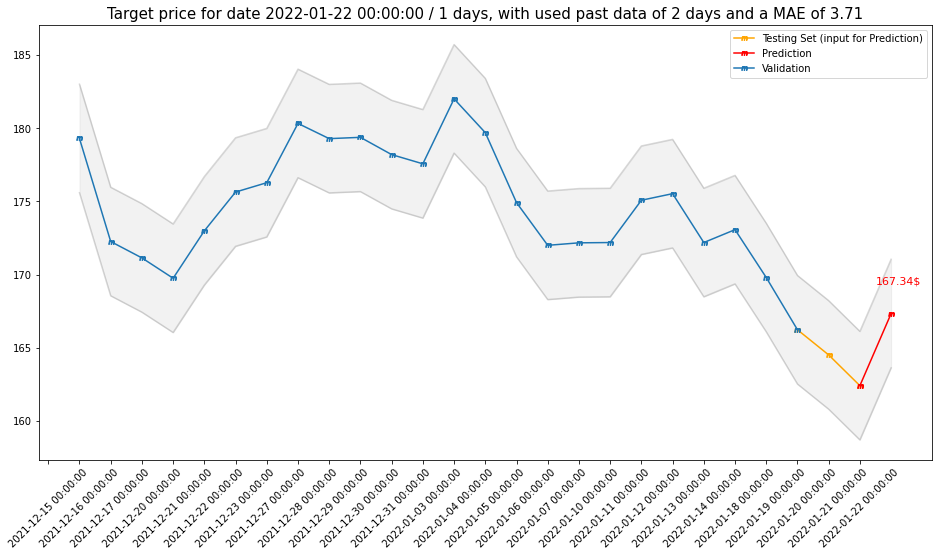


-----------------------------------------------------------------------------



In [34]:
plotting(y_val, y_test, pred_test, mae, WINDOW, PREDICTION_SCOPE)

## MULTIPLE EVALUATIONS

In [16]:
plots = {}


for window in [1, 2, 3, 4, 5, 6, 7]:
    
    for pred_scope in [0 ,1, 2, 4, 5, 6]:

        WINDOW = window
        PREDICTION_SCOPE = pred_scope

        train = stock_prices.iloc[:int(len(stock_prices))-WINDOW]
        test = stock_prices.iloc[-WINDOW:]
        
        train_set, validation_set = train_validation_split(train, PERCENTAGE)

        X_train, y_train, X_val, y_val = windowing(train_set, validation_set, WINDOW, PREDICTION_SCOPE)
        #The shaded area is used if we wanted to validate the model. I am using the last data in order to make a prediction

        X_train = np.array(X_train)
        y_train = np.array(y_train)

        X_val = np.array(X_val)
        y_val = np.array(y_val)

        X_test = np.array(test.iloc[:, :-1])
        y_test = np.array(test.iloc[:, -1])

        X_train = X_train.reshape(X_train.shape[0], -1)
        X_val = X_val.reshape(X_val.shape[0], -1)
        X_test = X_test.reshape(1, -1)

        xgb_model = xgb.XGBRegressor()
        xgb_model.fit(X_train, y_train)

        pred_val = xgb_model.predict(X_val)

        mae = mean_absolute_error(y_val, pred_val)

        pred_test = xgb_model.predict(X_test)
        plotii= [y_test[-1], pred_test]

        plots[str(window)+str(pred_scope)] = [y_val, y_test, pred_test, mae, WINDOW, PREDICTION_SCOPE]
    

In [48]:
plots

{'10': [array([179.30000305, 172.25999451, 171.13999939, 169.75      ,
         172.99000549, 175.63999939, 176.27999878, 180.33000183,
         179.28999329, 179.38000488, 178.19999695, 177.57000732,
         182.00999451, 179.69999695, 174.91999817, 172.        ,
         172.16999817, 172.19000244, 175.08000183, 175.52999878,
         172.19000244, 173.07000732, 169.80000305, 166.22999573,
         164.50999451]),
  array([162.41000366]),
  array([164.53902], dtype=float32),
  4.167745971679688,
  1,
  0],
 '11': [array([172.25999451, 171.13999939, 169.75      , 172.99000549,
         175.63999939, 176.27999878, 180.33000183, 179.28999329,
         179.38000488, 178.19999695, 177.57000732, 182.00999451,
         179.69999695, 174.91999817, 172.        , 172.16999817,
         172.19000244, 175.08000183, 175.52999878, 172.19000244,
         173.07000732, 169.80000305, 166.22999573, 164.50999451]),
  array([162.41000366]),
  array([174.15842], dtype=float32),
  3.5074450174967446,
  1

For used windowed data: 1
Prediction scope for date 2022-01-22 00:00:00 / 1 days
The predicted price is 164.54$
With a spread of MAE is 4.17



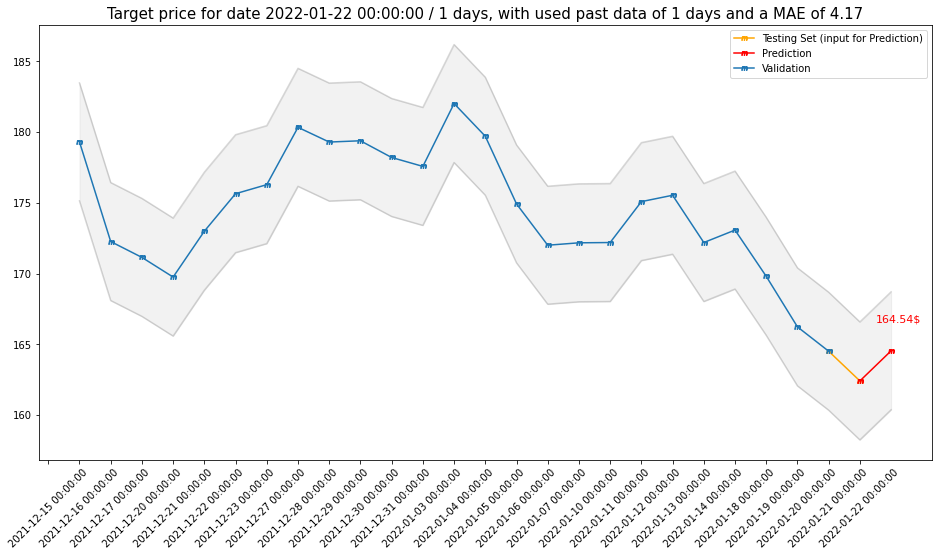


-----------------------------------------------------------------------------

For used windowed data: 1
Prediction scope for date 2022-01-23 00:00:00 / 2 days
The predicted price is 174.16$
With a spread of MAE is 3.51



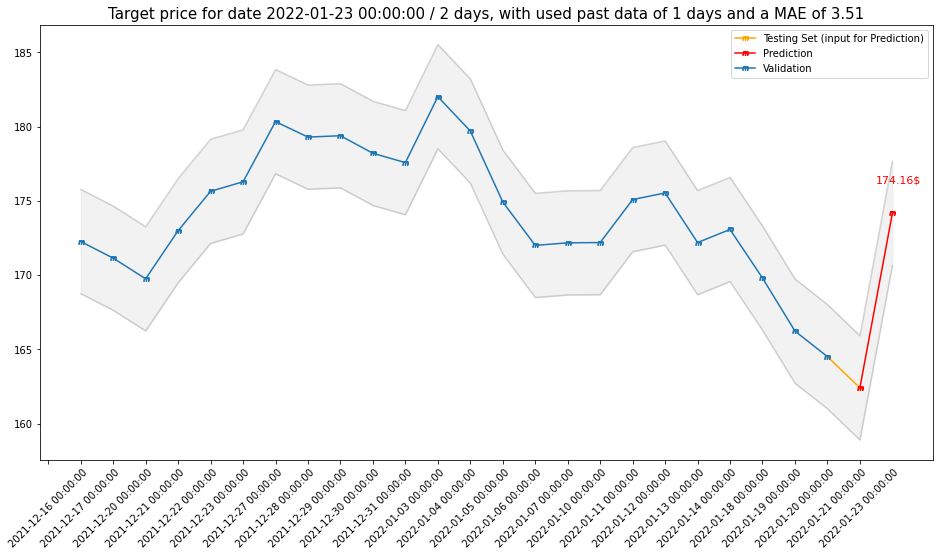


-----------------------------------------------------------------------------

For used windowed data: 1
Prediction scope for date 2022-01-24 00:00:00 / 3 days
The predicted price is 172.89$
With a spread of MAE is 4.63



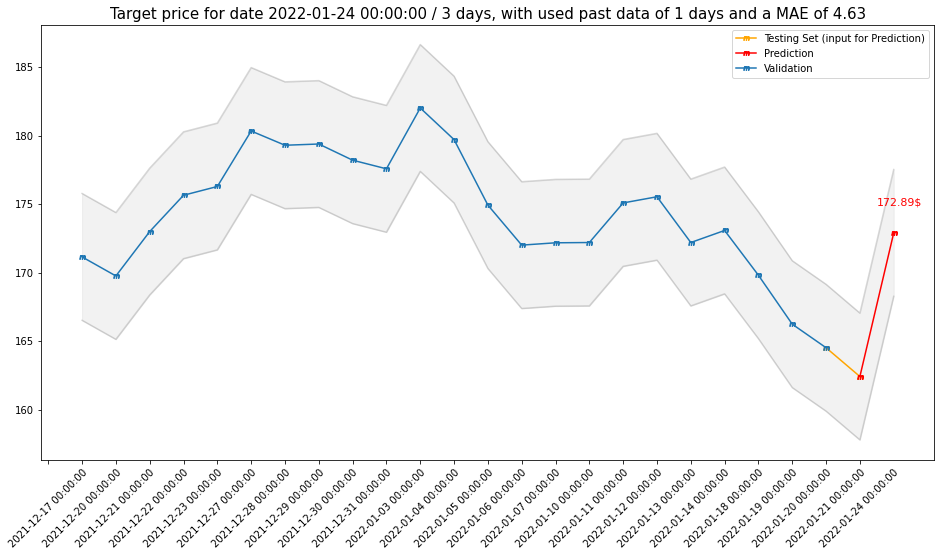


-----------------------------------------------------------------------------

For used windowed data: 1
Prediction scope for date 2022-01-26 00:00:00 / 5 days
The predicted price is 172.76$
With a spread of MAE is 5.3



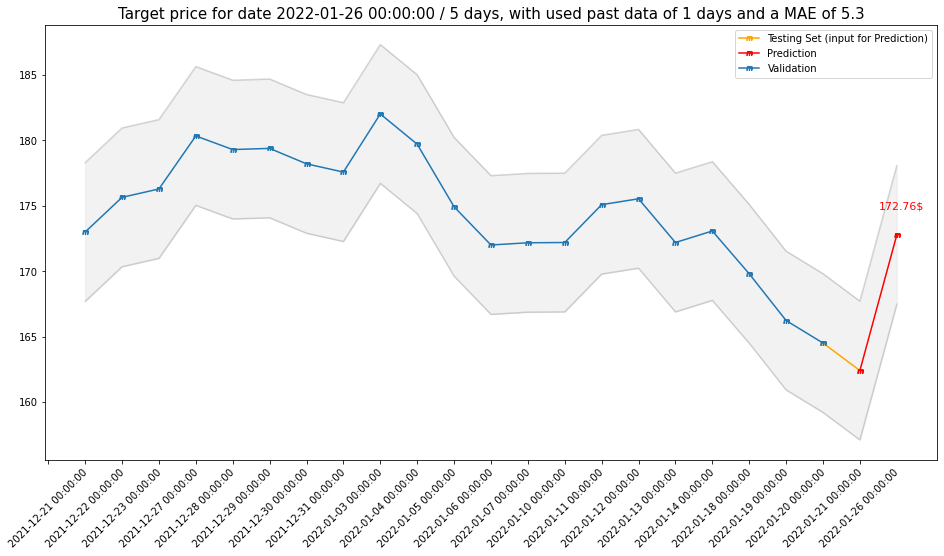


-----------------------------------------------------------------------------

For used windowed data: 1
Prediction scope for date 2022-01-27 00:00:00 / 6 days
The predicted price is 175.7$
With a spread of MAE is 4.3



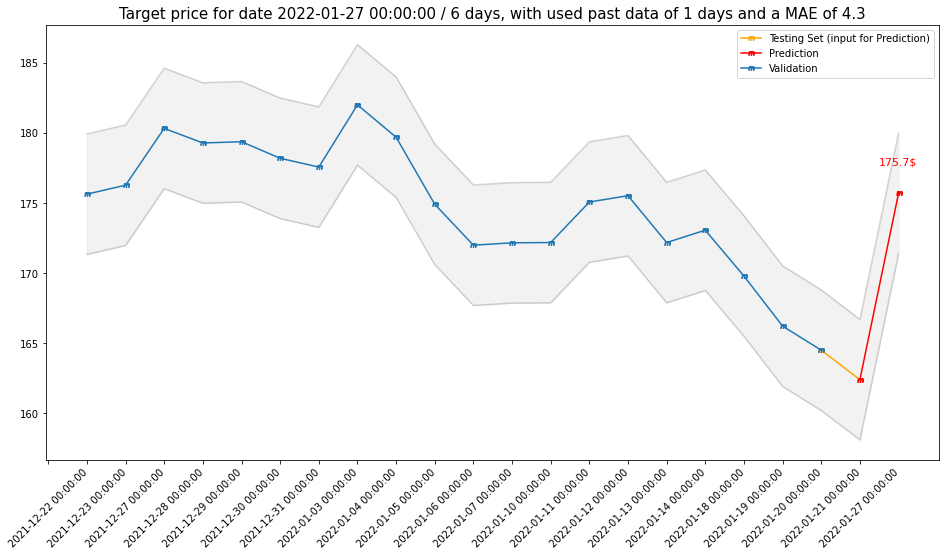


-----------------------------------------------------------------------------

For used windowed data: 1
Prediction scope for date 2022-01-28 00:00:00 / 7 days
The predicted price is 166.62$
With a spread of MAE is 5.01



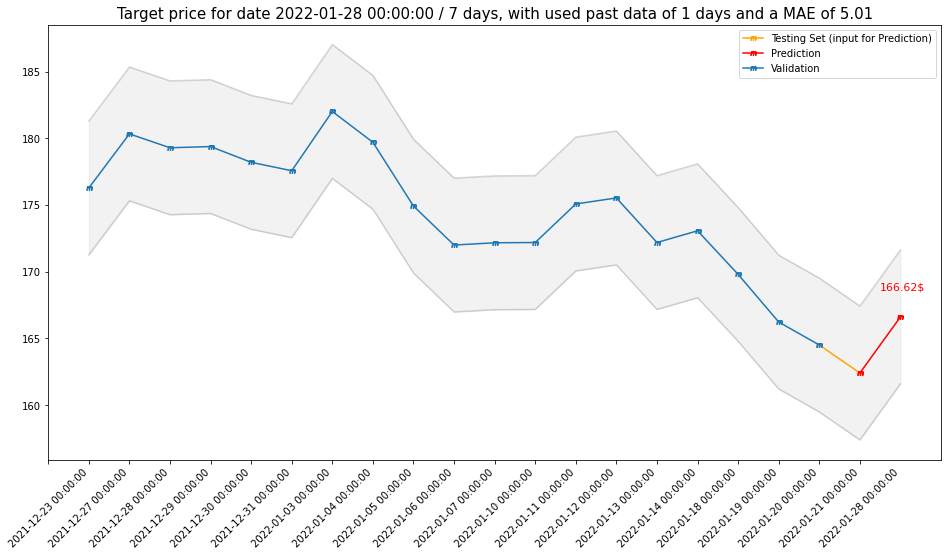


-----------------------------------------------------------------------------

For used windowed data: 2
Prediction scope for date 2022-01-22 00:00:00 / 1 days
The predicted price is 166.57$
With a spread of MAE is 4.12



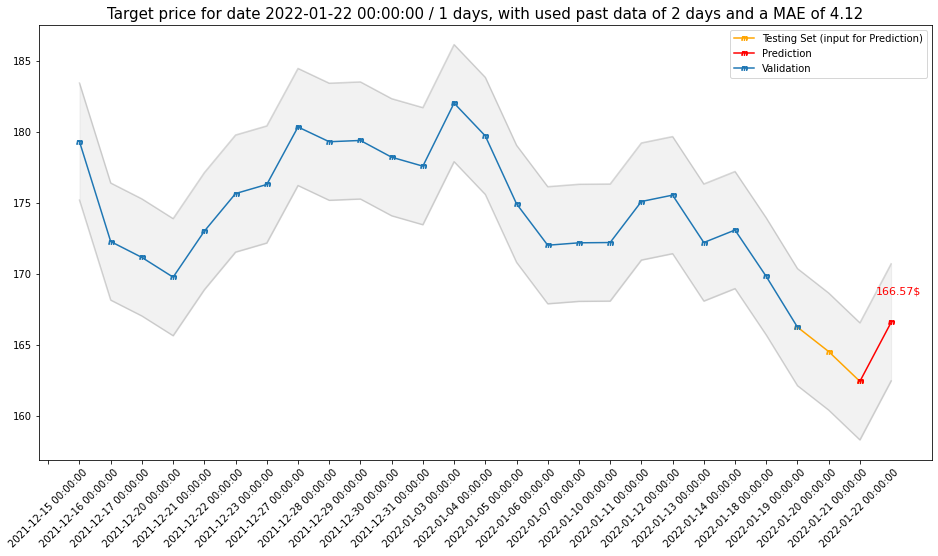


-----------------------------------------------------------------------------

For used windowed data: 2
Prediction scope for date 2022-01-23 00:00:00 / 2 days
The predicted price is 173.36$
With a spread of MAE is 3.89



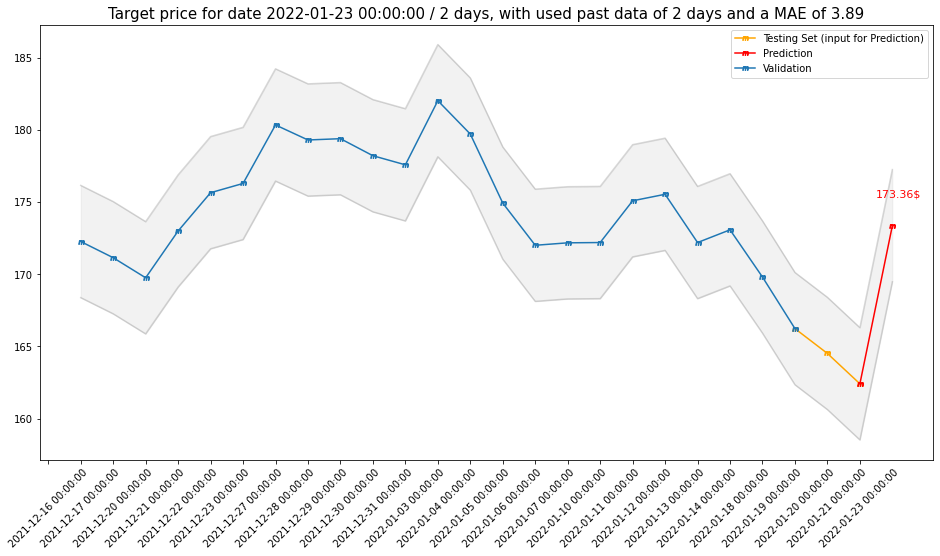


-----------------------------------------------------------------------------

For used windowed data: 2
Prediction scope for date 2022-01-24 00:00:00 / 3 days
The predicted price is 167.09$
With a spread of MAE is 5.22



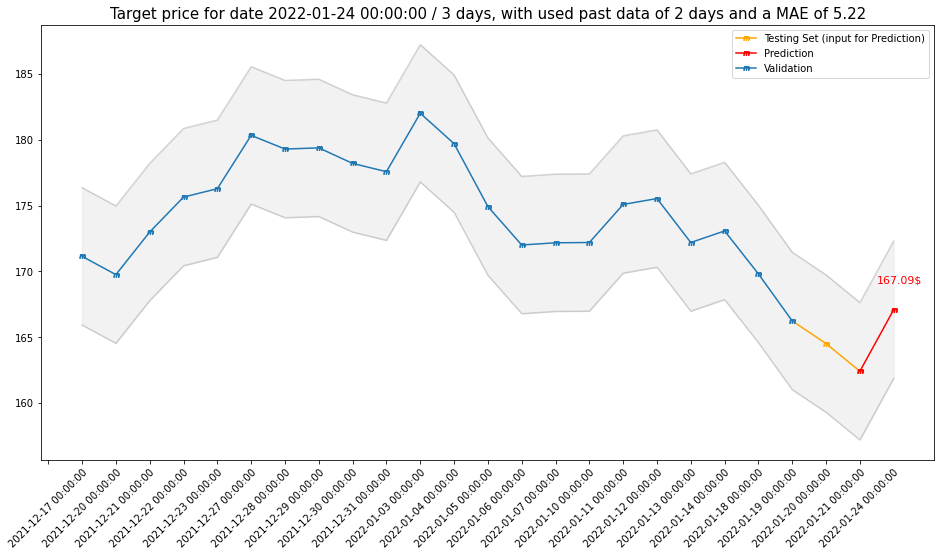


-----------------------------------------------------------------------------

For used windowed data: 2
Prediction scope for date 2022-01-26 00:00:00 / 5 days
The predicted price is 173.92$
With a spread of MAE is 3.96



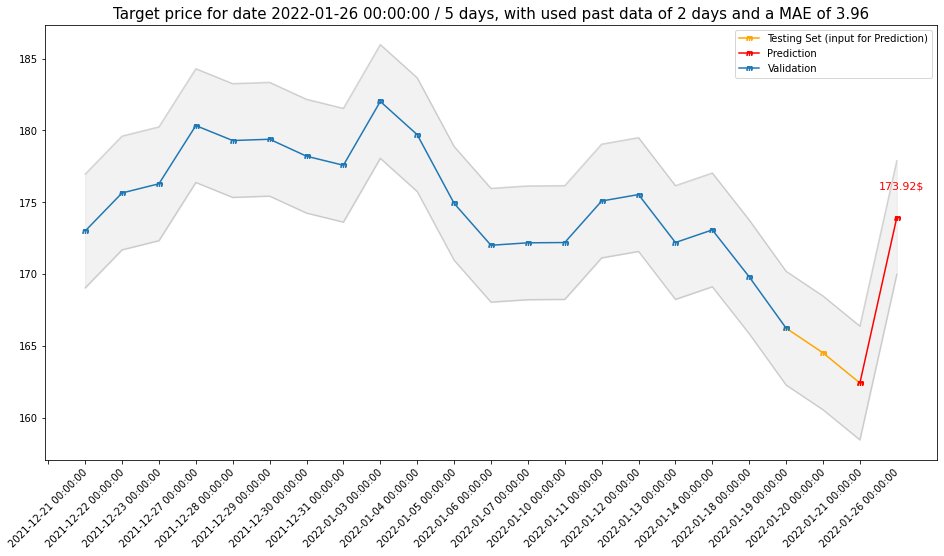


-----------------------------------------------------------------------------

For used windowed data: 2
Prediction scope for date 2022-01-27 00:00:00 / 6 days
The predicted price is 168.45$
With a spread of MAE is 4.15



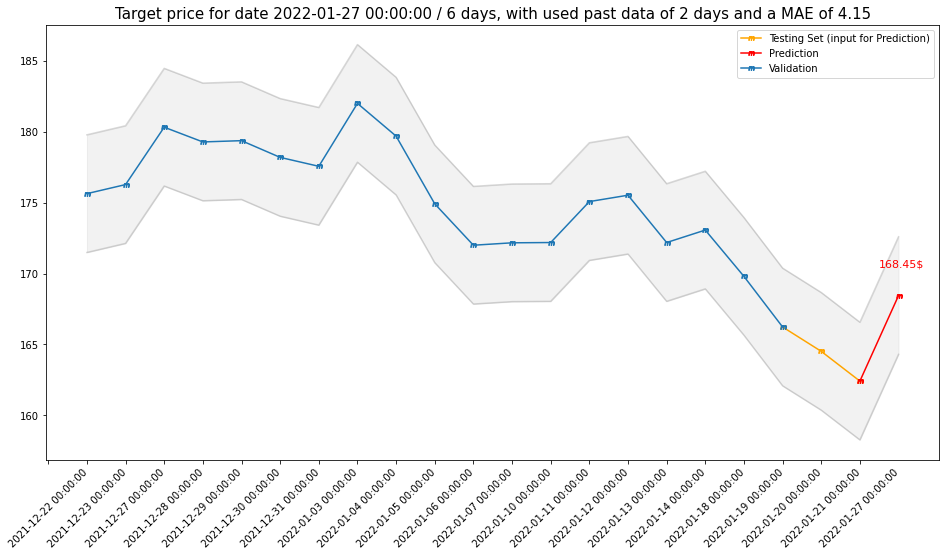


-----------------------------------------------------------------------------

For used windowed data: 2
Prediction scope for date 2022-01-28 00:00:00 / 7 days
The predicted price is 167.69$
With a spread of MAE is 11.5



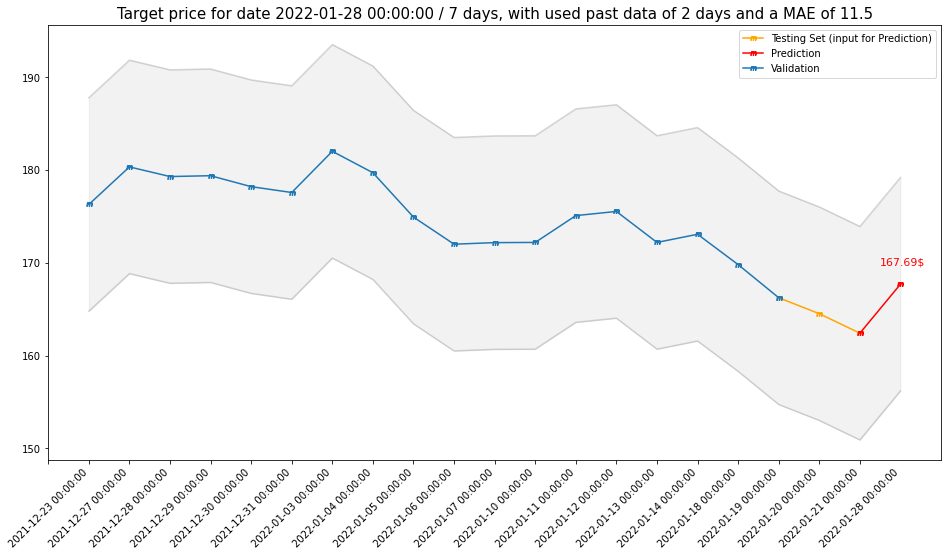


-----------------------------------------------------------------------------

For used windowed data: 3
Prediction scope for date 2022-01-22 00:00:00 / 1 days
The predicted price is 167.32$
With a spread of MAE is 3.35



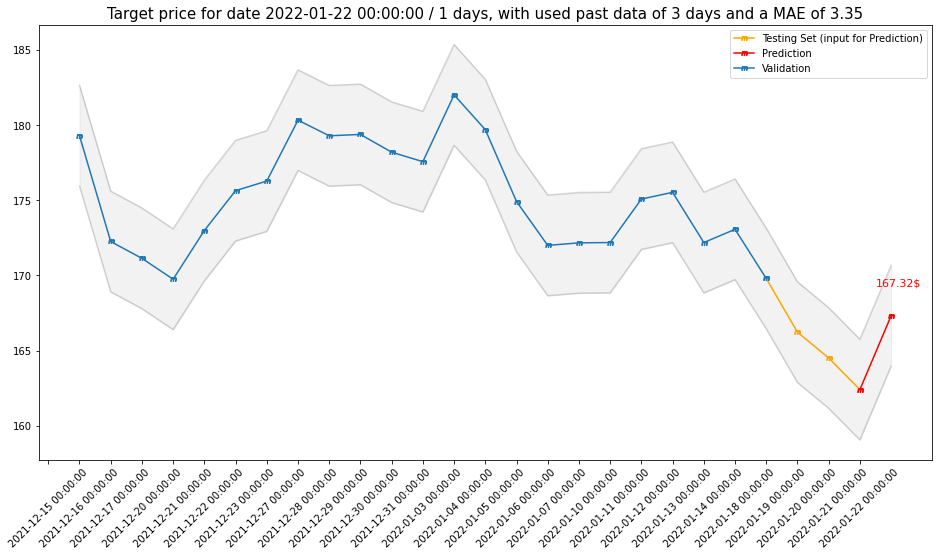


-----------------------------------------------------------------------------

For used windowed data: 3
Prediction scope for date 2022-01-23 00:00:00 / 2 days
The predicted price is 171.08$
With a spread of MAE is 3.69



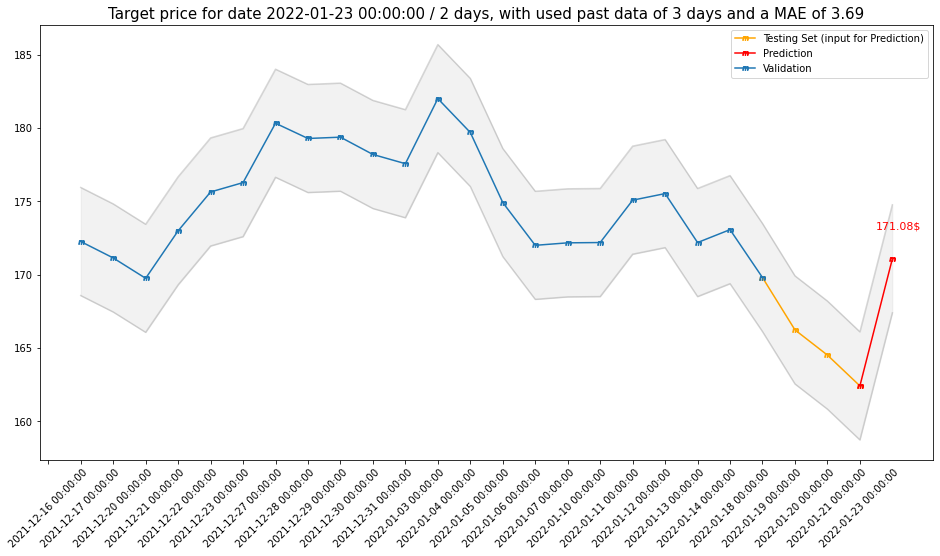


-----------------------------------------------------------------------------

For used windowed data: 3
Prediction scope for date 2022-01-24 00:00:00 / 3 days
The predicted price is 170.39$
With a spread of MAE is 5.18



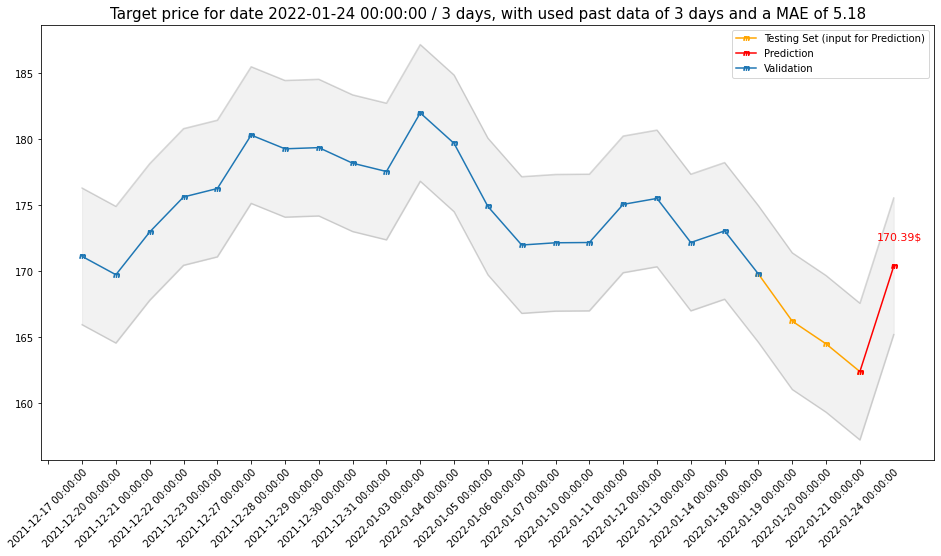


-----------------------------------------------------------------------------

For used windowed data: 3
Prediction scope for date 2022-01-26 00:00:00 / 5 days
The predicted price is 167.77$
With a spread of MAE is 5.54



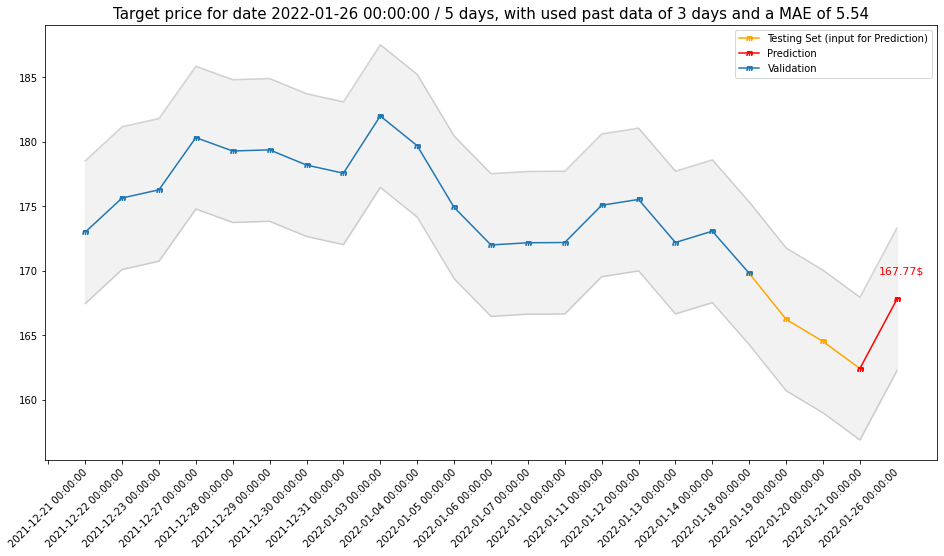


-----------------------------------------------------------------------------

For used windowed data: 3
Prediction scope for date 2022-01-27 00:00:00 / 6 days
The predicted price is 163.6$
With a spread of MAE is 10.43



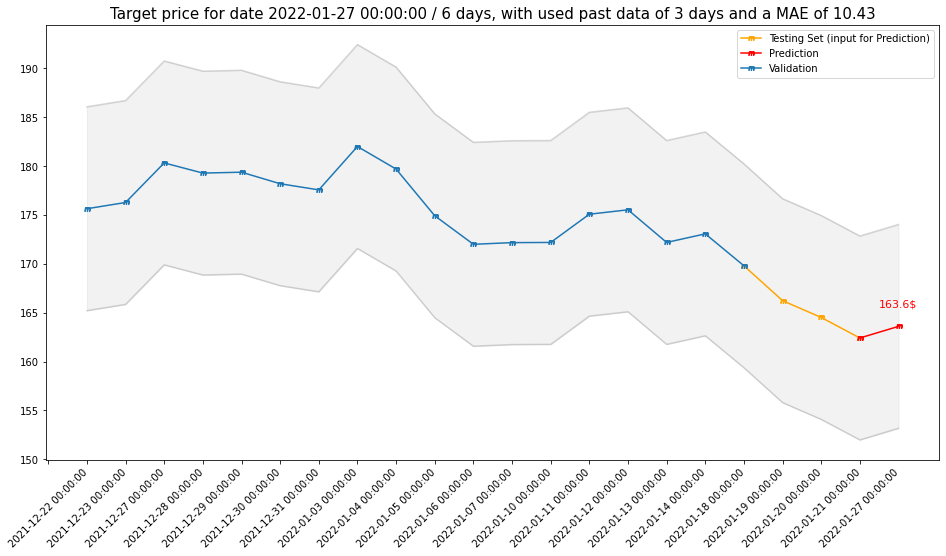


-----------------------------------------------------------------------------

For used windowed data: 3
Prediction scope for date 2022-01-28 00:00:00 / 7 days
The predicted price is 166.08$
With a spread of MAE is 11.17



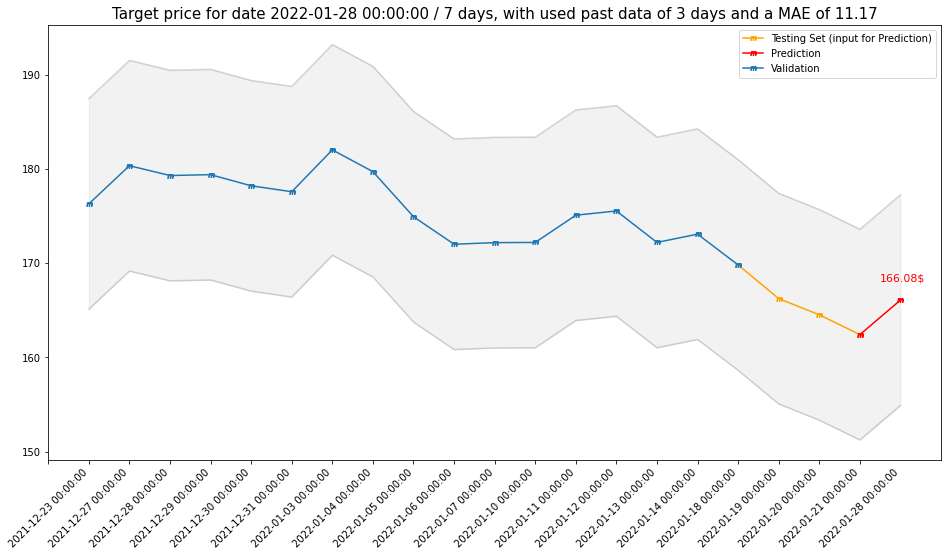


-----------------------------------------------------------------------------

For used windowed data: 4
Prediction scope for date 2022-01-22 00:00:00 / 1 days
The predicted price is 165.85$
With a spread of MAE is 5.43



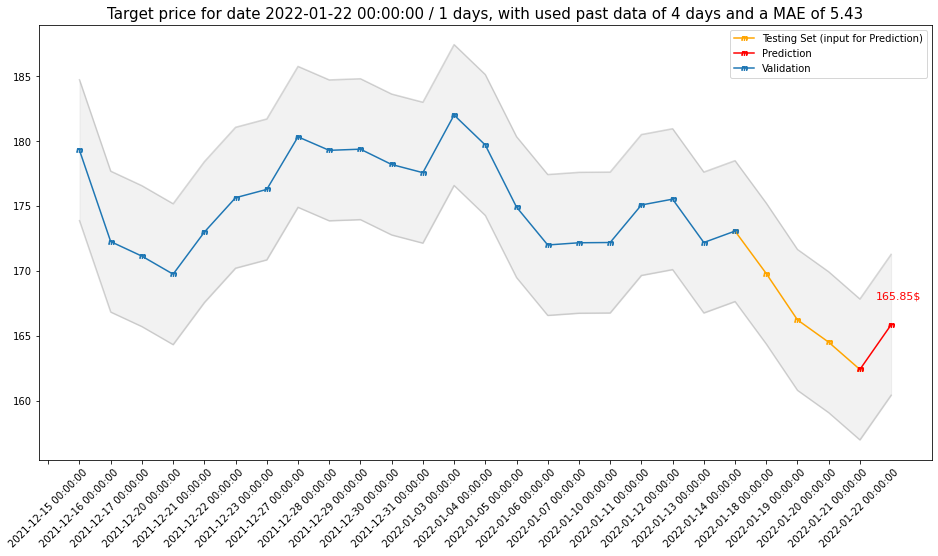


-----------------------------------------------------------------------------

For used windowed data: 4
Prediction scope for date 2022-01-23 00:00:00 / 2 days
The predicted price is 170.27$
With a spread of MAE is 6.26



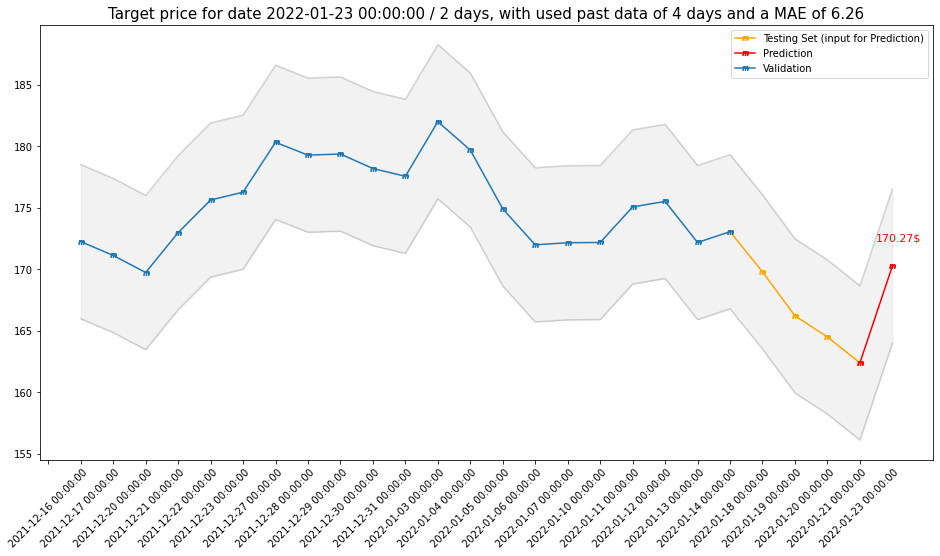


-----------------------------------------------------------------------------

For used windowed data: 4
Prediction scope for date 2022-01-24 00:00:00 / 3 days
The predicted price is 170.93$
With a spread of MAE is 4.92



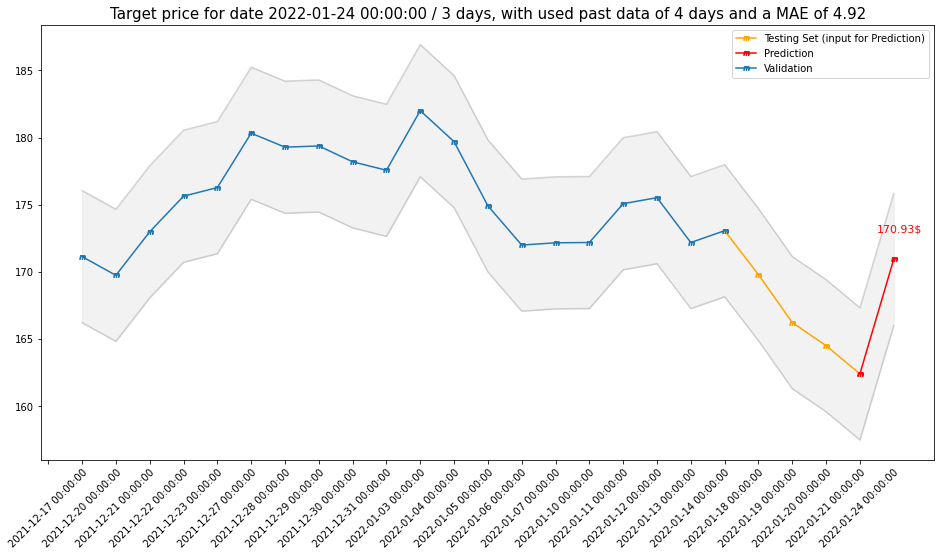


-----------------------------------------------------------------------------

For used windowed data: 4
Prediction scope for date 2022-01-26 00:00:00 / 5 days
The predicted price is 164.14$
With a spread of MAE is 7.17



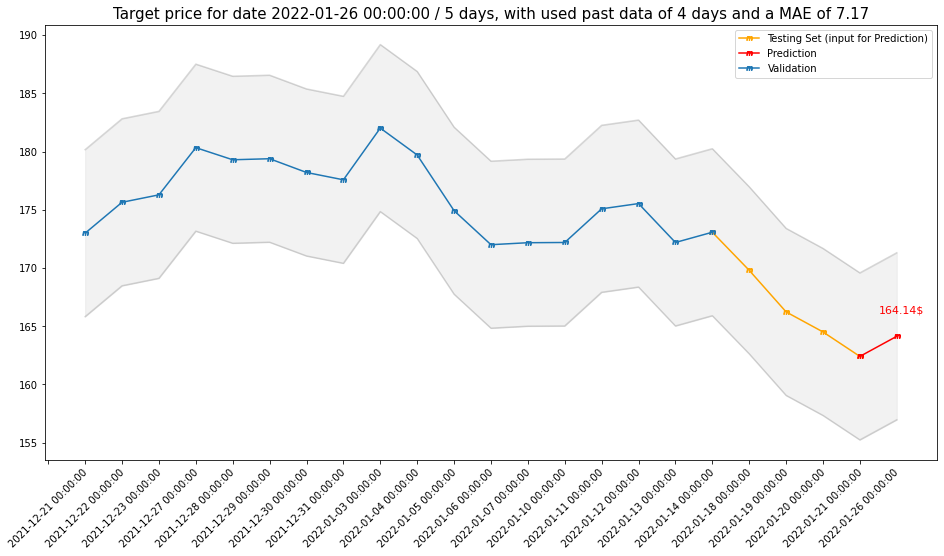


-----------------------------------------------------------------------------

For used windowed data: 4
Prediction scope for date 2022-01-27 00:00:00 / 6 days
The predicted price is 168.31$
With a spread of MAE is 10.98



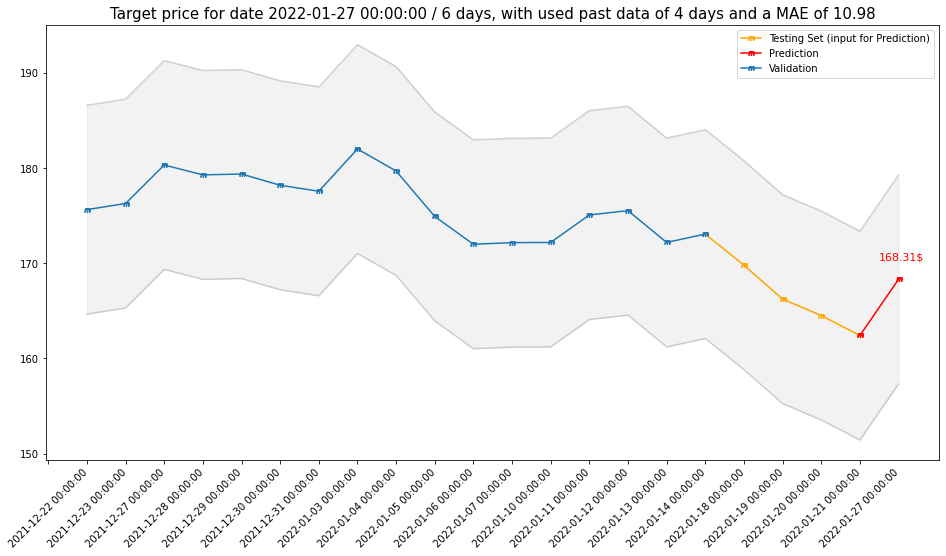


-----------------------------------------------------------------------------

For used windowed data: 4
Prediction scope for date 2022-01-28 00:00:00 / 7 days
The predicted price is 168.94$
With a spread of MAE is 8.08



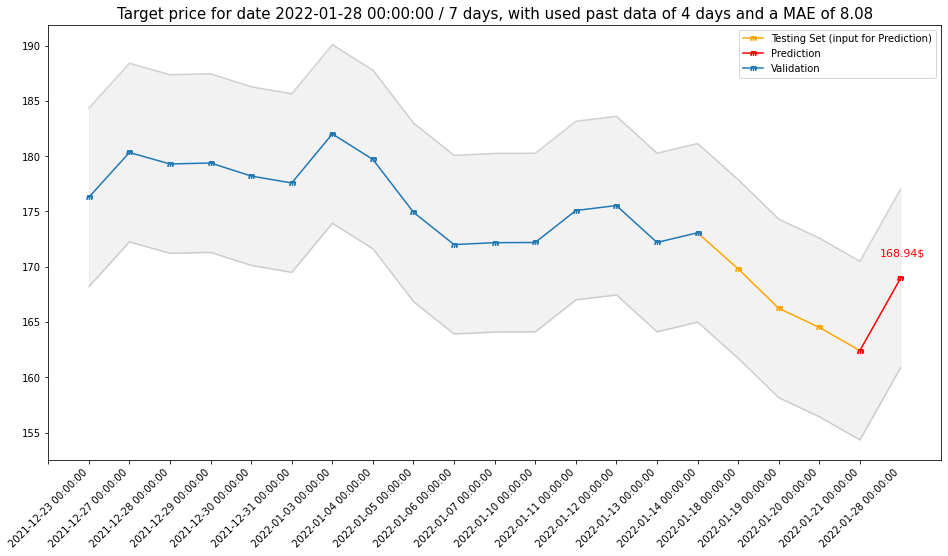


-----------------------------------------------------------------------------

For used windowed data: 5
Prediction scope for date 2022-01-22 00:00:00 / 1 days
The predicted price is 164.95$
With a spread of MAE is 11.42



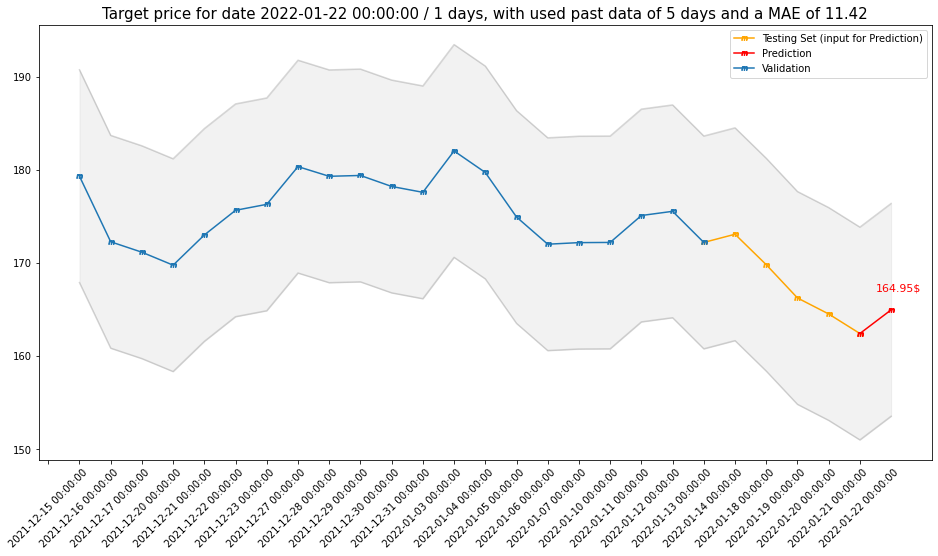


-----------------------------------------------------------------------------

For used windowed data: 5
Prediction scope for date 2022-01-23 00:00:00 / 2 days
The predicted price is 167.38$
With a spread of MAE is 9.84



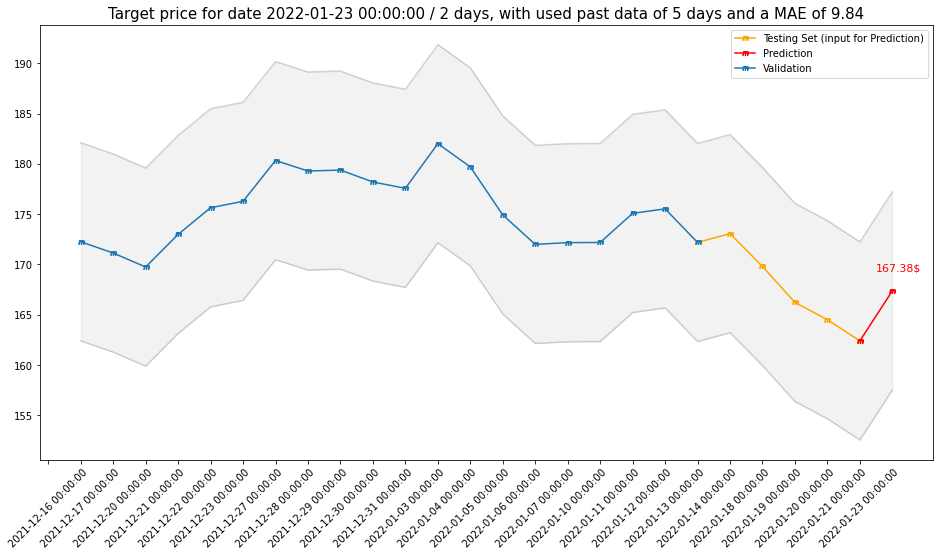


-----------------------------------------------------------------------------

For used windowed data: 5
Prediction scope for date 2022-01-24 00:00:00 / 3 days
The predicted price is 166.94$
With a spread of MAE is 11.13



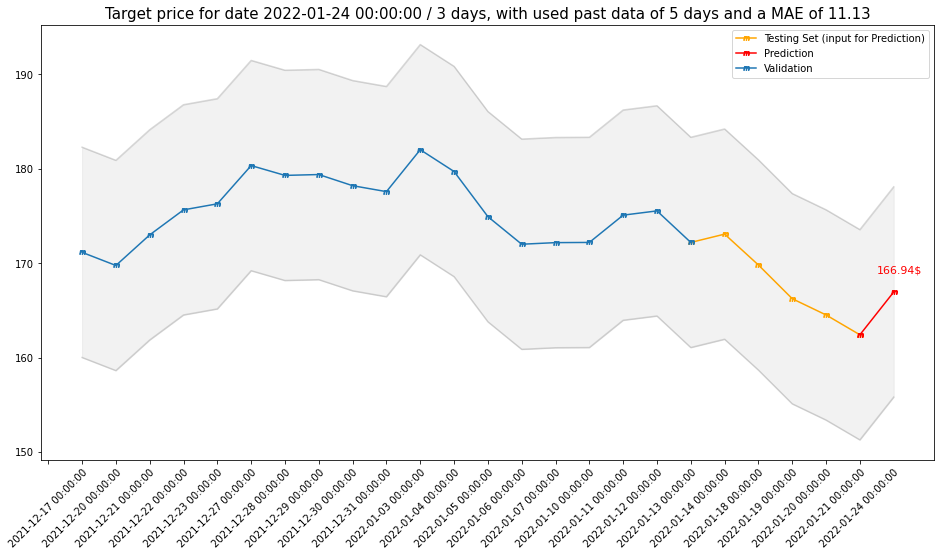


-----------------------------------------------------------------------------

For used windowed data: 5
Prediction scope for date 2022-01-26 00:00:00 / 5 days
The predicted price is 162.04$
With a spread of MAE is 14.99



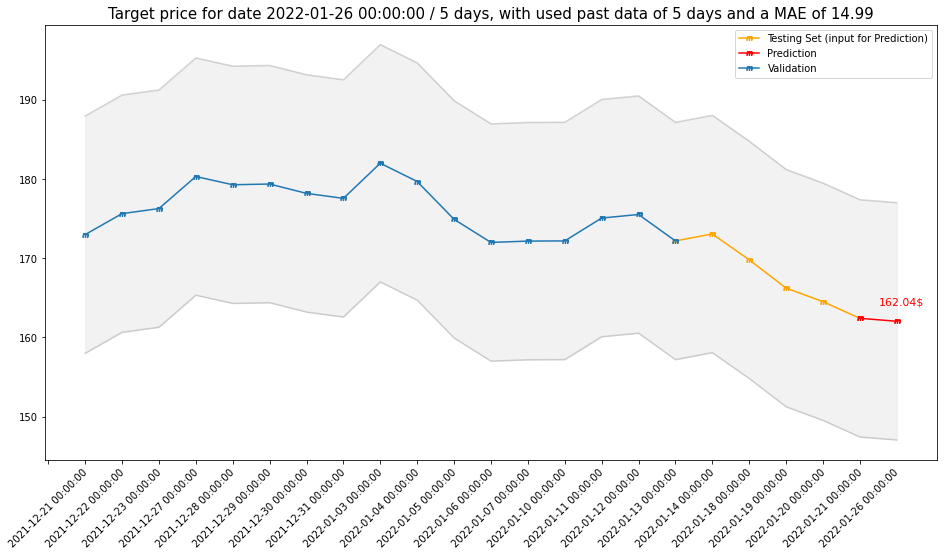


-----------------------------------------------------------------------------

For used windowed data: 5
Prediction scope for date 2022-01-27 00:00:00 / 6 days
The predicted price is 164.47$
With a spread of MAE is 13.91



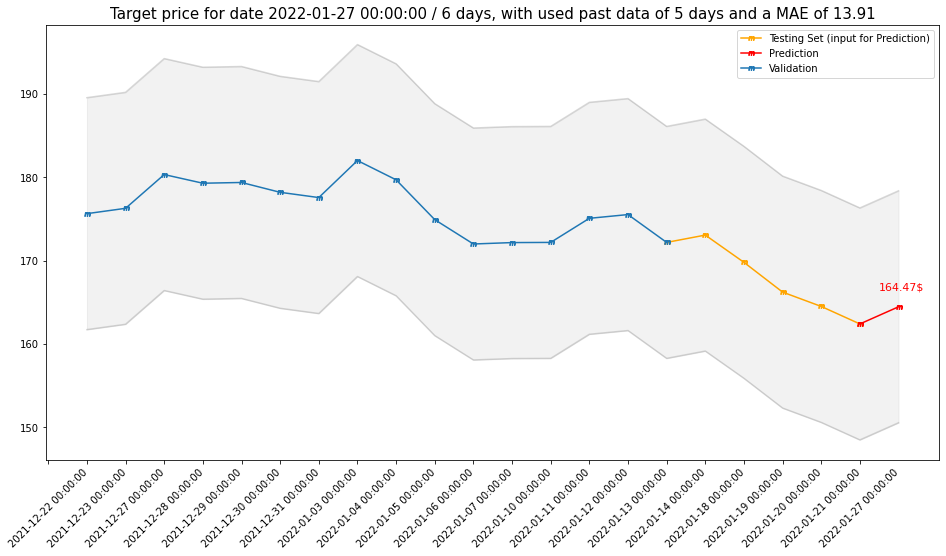


-----------------------------------------------------------------------------

For used windowed data: 5
Prediction scope for date 2022-01-28 00:00:00 / 7 days
The predicted price is 165.85$
With a spread of MAE is 13.35



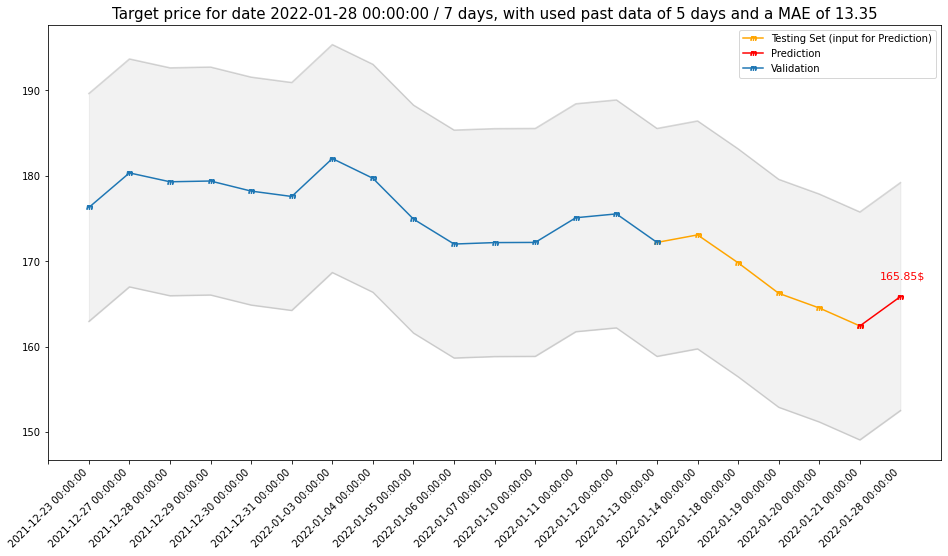


-----------------------------------------------------------------------------

For used windowed data: 6
Prediction scope for date 2022-01-22 00:00:00 / 1 days
The predicted price is 164.55$
With a spread of MAE is 12.44



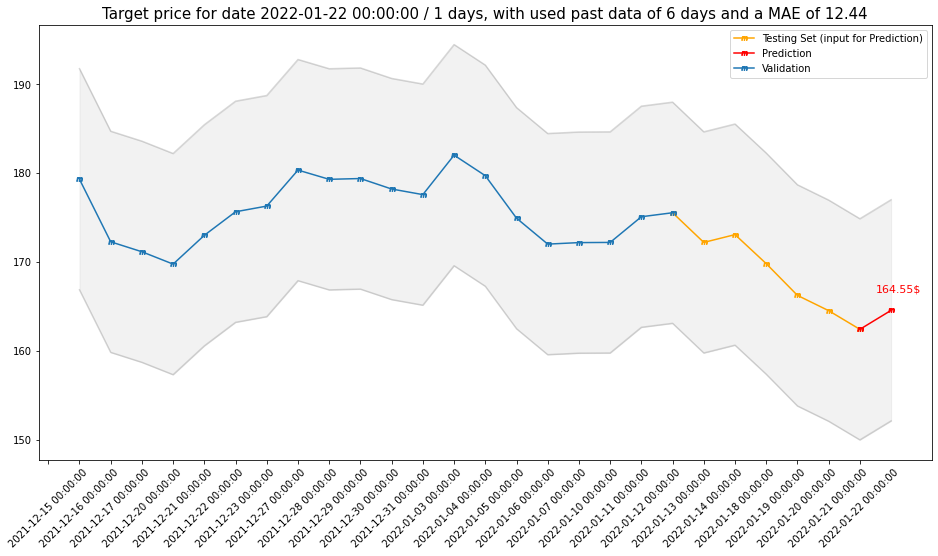


-----------------------------------------------------------------------------

For used windowed data: 6
Prediction scope for date 2022-01-23 00:00:00 / 2 days
The predicted price is 163.88$
With a spread of MAE is 13.29



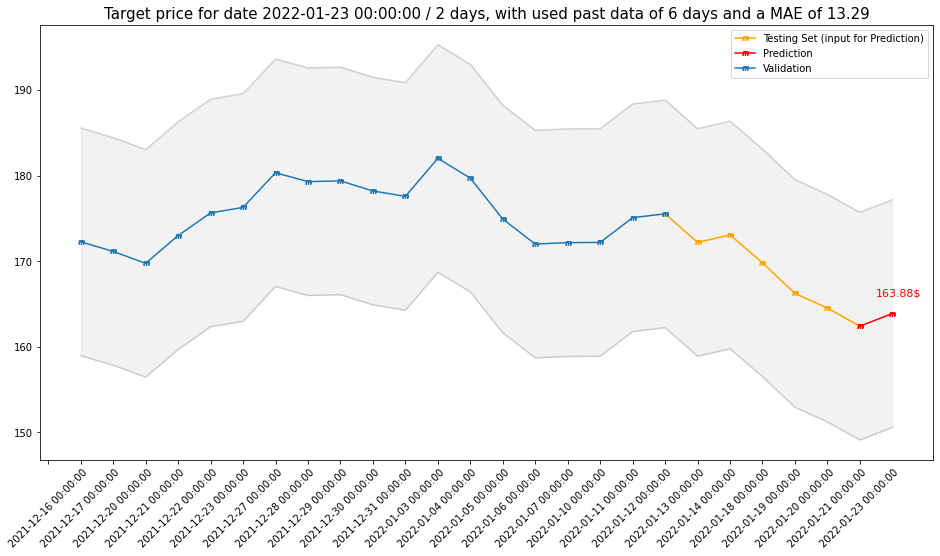


-----------------------------------------------------------------------------

For used windowed data: 6
Prediction scope for date 2022-01-24 00:00:00 / 3 days
The predicted price is 163.2$
With a spread of MAE is 14.91



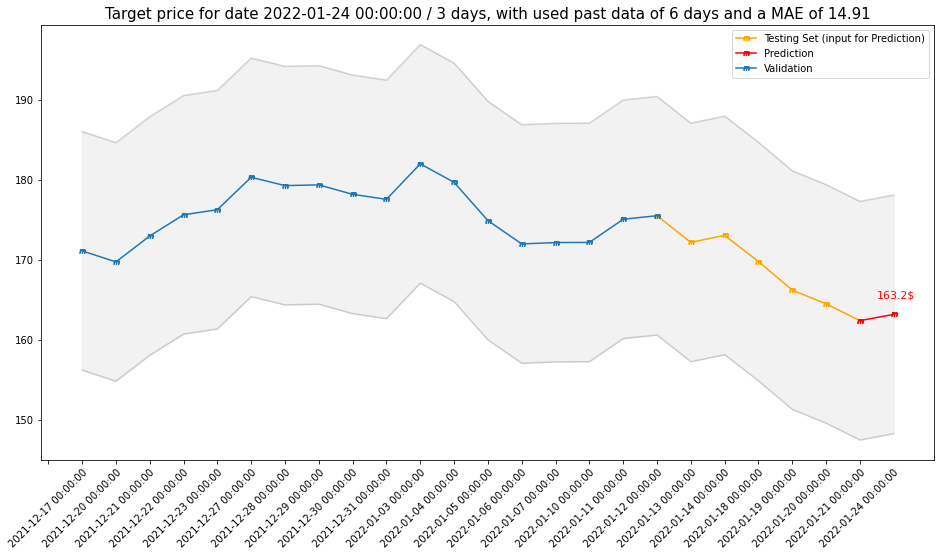


-----------------------------------------------------------------------------

For used windowed data: 6
Prediction scope for date 2022-01-26 00:00:00 / 5 days
The predicted price is 164.19$
With a spread of MAE is 14.38



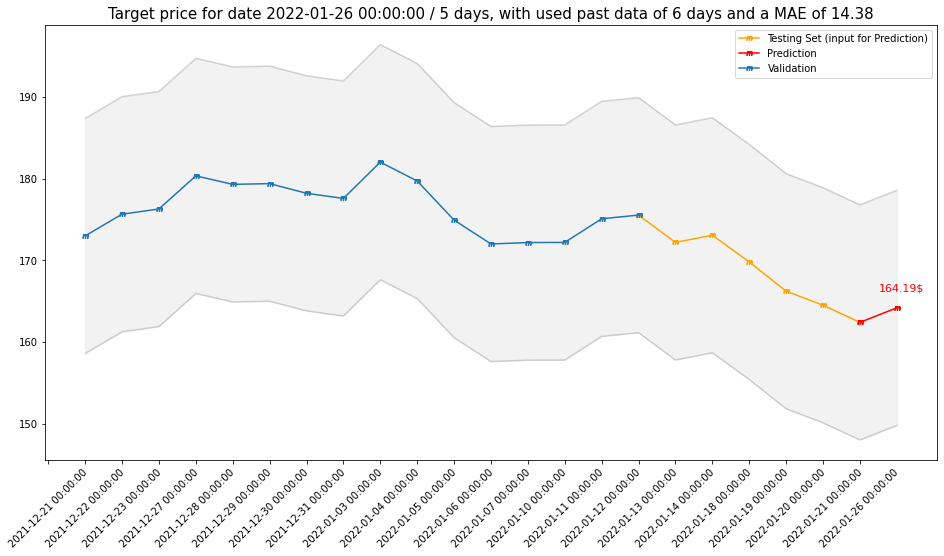


-----------------------------------------------------------------------------

For used windowed data: 6
Prediction scope for date 2022-01-27 00:00:00 / 6 days
The predicted price is 153.55$
With a spread of MAE is 25.13



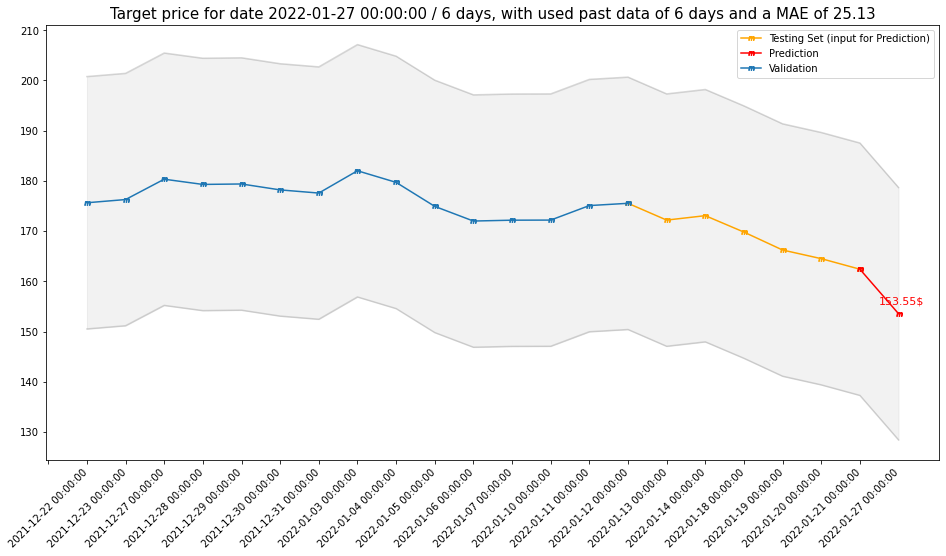


-----------------------------------------------------------------------------

For used windowed data: 6
Prediction scope for date 2022-01-28 00:00:00 / 7 days
The predicted price is 154.04$
With a spread of MAE is 22.49



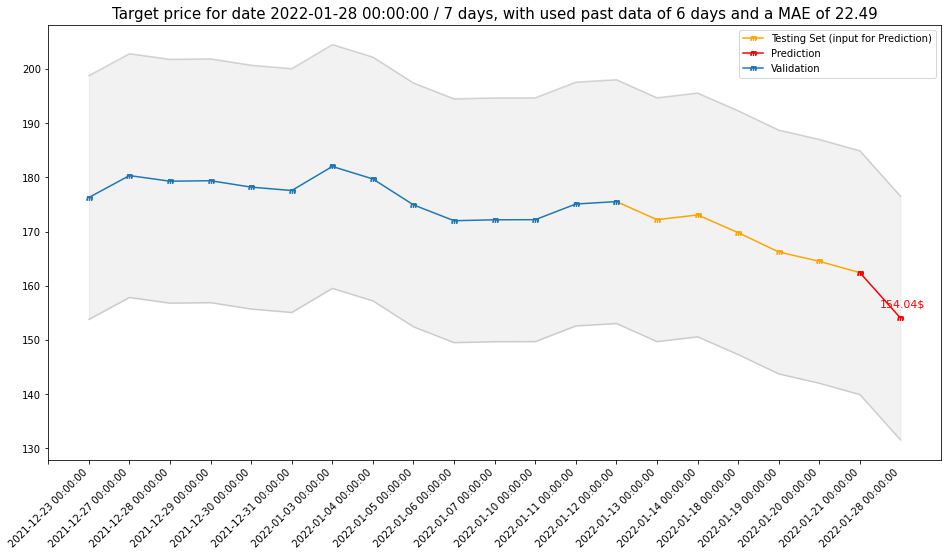


-----------------------------------------------------------------------------

For used windowed data: 7
Prediction scope for date 2022-01-22 00:00:00 / 1 days
The predicted price is 162.42$
With a spread of MAE is 13.63



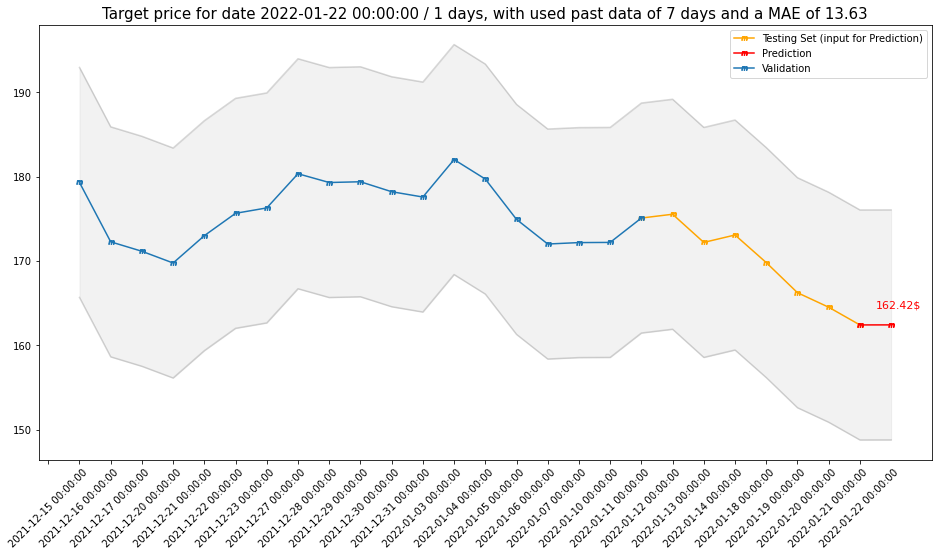


-----------------------------------------------------------------------------

For used windowed data: 7
Prediction scope for date 2022-01-23 00:00:00 / 2 days
The predicted price is 163.76$
With a spread of MAE is 13.73



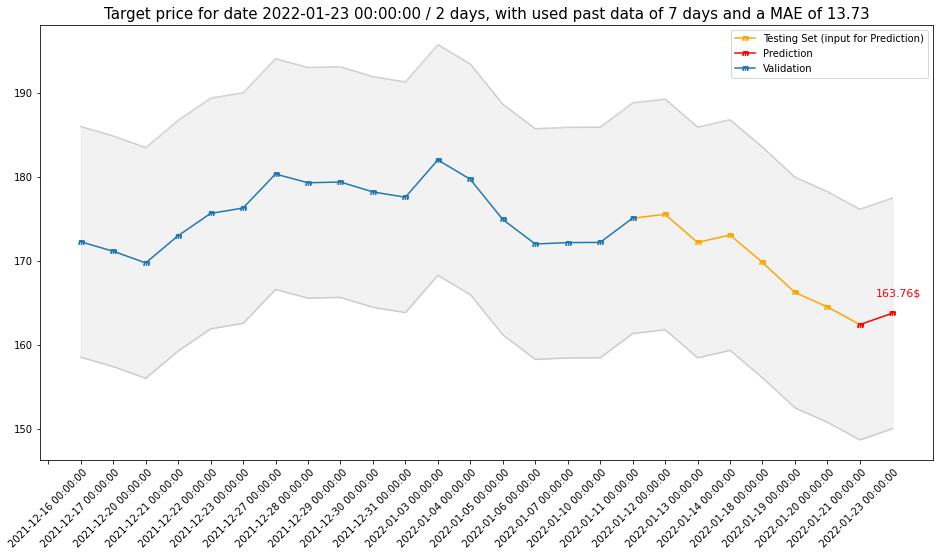


-----------------------------------------------------------------------------

For used windowed data: 7
Prediction scope for date 2022-01-24 00:00:00 / 3 days
The predicted price is 161.35$
With a spread of MAE is 14.31



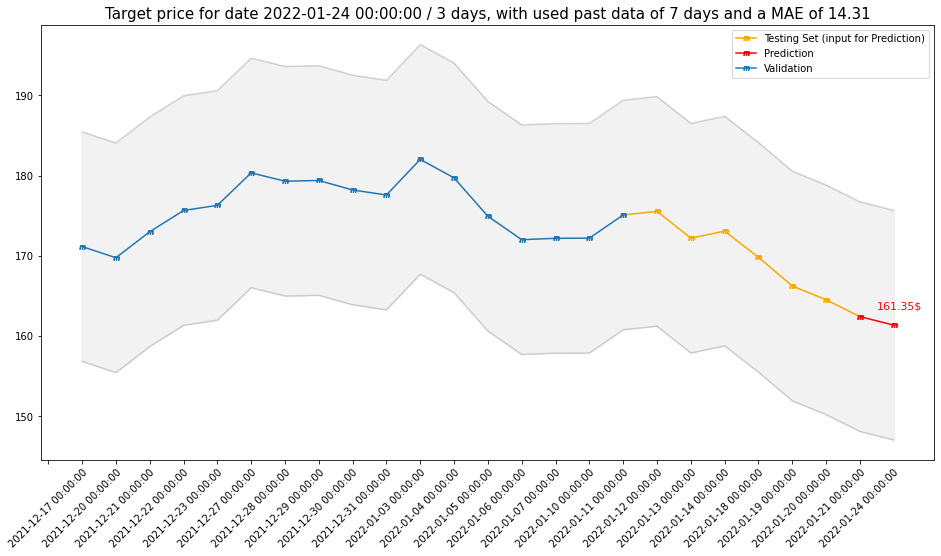


-----------------------------------------------------------------------------

For used windowed data: 7
Prediction scope for date 2022-01-26 00:00:00 / 5 days
The predicted price is 159.23$
With a spread of MAE is 18.71



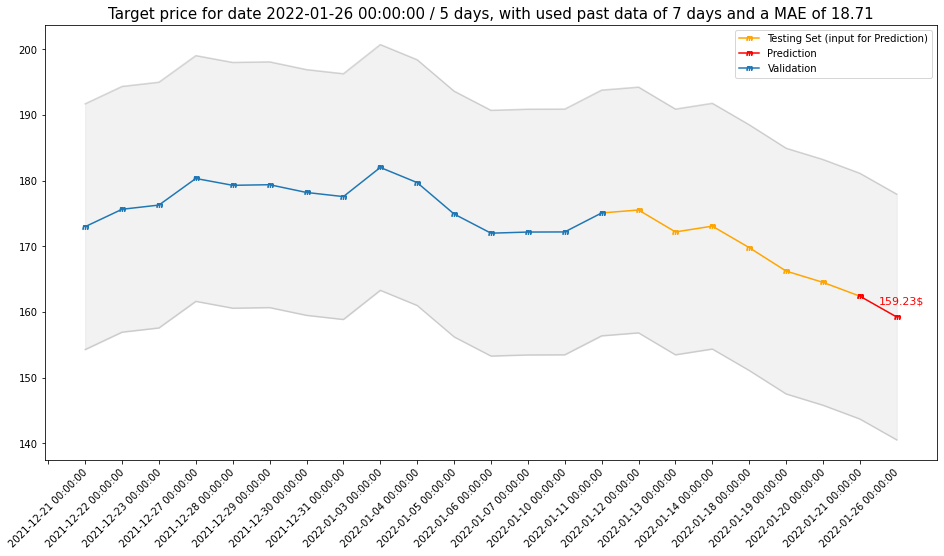


-----------------------------------------------------------------------------

For used windowed data: 7
Prediction scope for date 2022-01-27 00:00:00 / 6 days
The predicted price is 152.82$
With a spread of MAE is 25.95



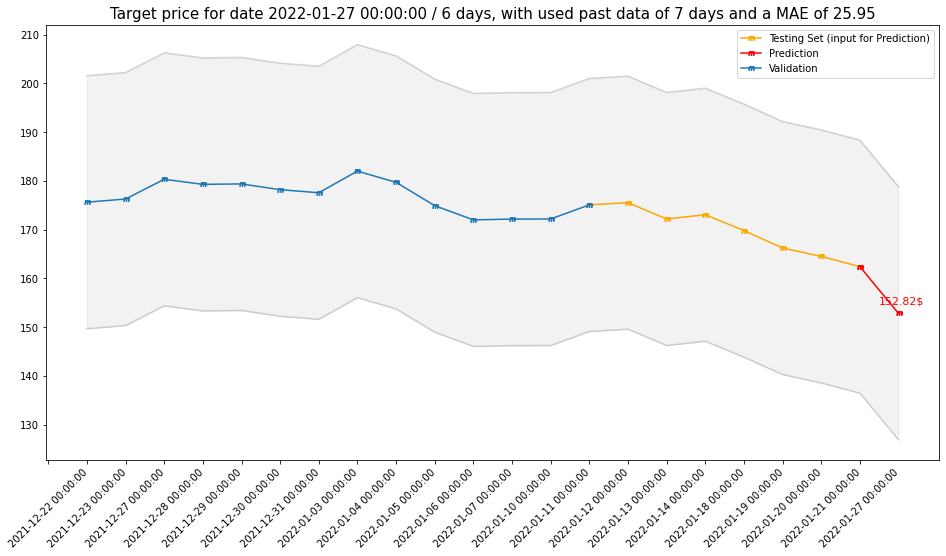


-----------------------------------------------------------------------------

For used windowed data: 7
Prediction scope for date 2022-01-28 00:00:00 / 7 days
The predicted price is 151.38$
With a spread of MAE is 28.78



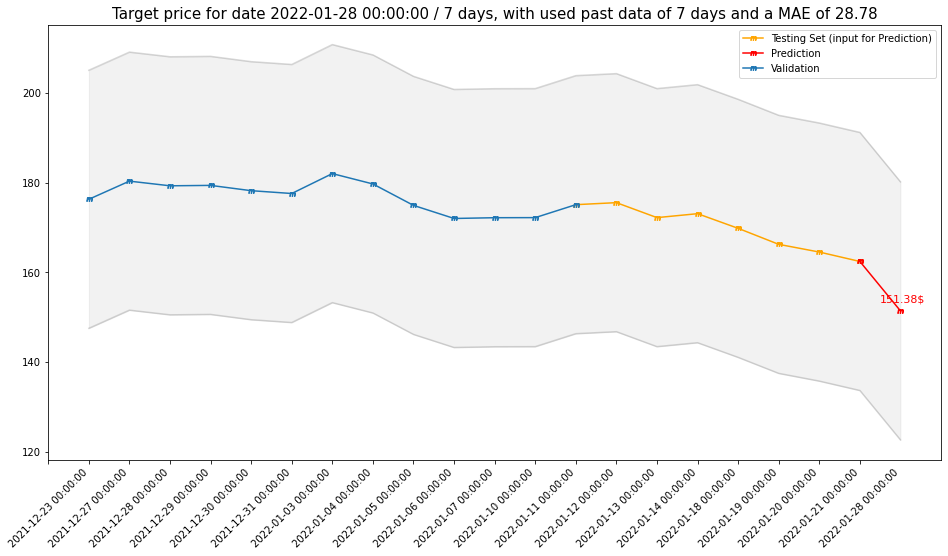


-----------------------------------------------------------------------------



In [18]:
for key in list(plots.keys()):
    plotting(plots[key][0], plots[key][1], plots[key][2], plots[key][3], plots[key][4], plots[key][5])


# Conclusion

In future updates of the code I will include an analysis of further time periods, and also a hybrid combination with an LSTM. 
Moreover, this analysis makes some assumptions that I wanted to mention aswell in further updated versions.
Stay tuned!